In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from method import IV
from simulator import Simulator
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from exana.statistics import plot_xcorr, permutation_resampling
from tools import savefig, fix_figure, coef_var, corrcoef, despine, set_style
import copy
from IPython.display import display
import statsmodels.api as sm

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [36]:
def model(x):
    return 1/(1+np.exp(-x))

def norm(x):
#     return (x - np.mean(x)) / np.std(x)
    return (x - min(x)) / (max(x) - min(x))

def mean_square_error(x1, x2, norm=None):
    if norm is not None:
        x1, x2 = norm(x1), norm(x2)
    return np.sum((x1 - x2)**2) / len(x1)

In [45]:
trials = [5000, 10000, 15000, 20000, 25000, 30000]
sim_id = [1, 2, 3]
# TOL = -np.inf
# txt = '_neg'
TOL = 0
txt = '_pos'
save = False
set_style('article')

In [46]:
mse = {}
for sid in sim_id:
    tmp = []
    for N_trials in trials:
        analys = pd.read_csv('results/params_{}_analyse_{}.csv'.format(sid, N_trials))
        cut = analys.loc[analys.wald > TOL, ['wald', 'weight']] # analys.wald > 0
        case, control = cut['wald'], cut['weight']
        tmp.append(mean_square_error(case, control, norm=norm))
    mse[sid] = {'mse': tmp}

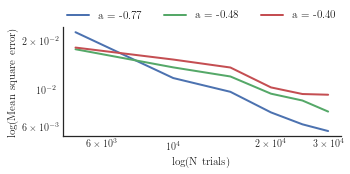

In [49]:
legend = {
    1: 'sim 1',
    2: 'sim 2',
    3: 'sim 3'
}
for sid in sim_id:
    slope, intercept = np.polyfit(np.log(trials), np.log(mse[sid]['mse']), 1)
    plt.loglog(trials, mse[sid]['mse'], label='a = {:.2f}'.format(slope))
despine()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)
plt.xlabel('log(N trials)')
plt.ylabel('log(Mean square error)')
if save: savefig(plt.gcf(), 'mse{}'.format(txt), bbox_inches='tight')
# plt.plot(trials, 1/trials, 'k')

In [17]:
analys['logit'] = model(analys.logreg + analys.logreg_intercept)

analys.loc[analys['wald'] < 0,'wald'] = 0

analys['cch'] = analys['trans_prob']
analys.loc[analys['cch'] < 0,'cch'] = 0


# analys.loc[(analys.pfast > 0.001) & (analys.pcausal > 0.001),'cch'] = np.nan

In [18]:
analys['weight'] = norm(analys['weight'])
analys['logit'] = norm(analys['logit'])
analys['wald'] = norm(analys['wald'])
analys['cch'] = norm(analys['cch'])

In [19]:
sum(analys.pcausal < 0.001)

330

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff97276fd0>,
      dtype=object)

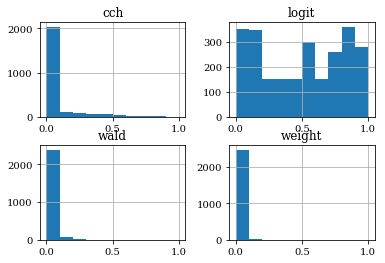

In [20]:
analys.loc[:, ['cch', 'logit', 'wald', 'weight']].hist()